# Exploratory Data Analysis

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc
from sklearn.linear_model import Lasso, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from project_utilities import single_set_data_cleaning

In [2]:
# read in the data
fifa_15 = pd.read_csv('data/players_15.csv')
fifa_16 = pd.read_csv('data/players_16.csv')
fifa_17 = pd.read_csv('data/players_17.csv')
fifa_18 = pd.read_csv('data/players_18.csv')
fifa_19 = pd.read_csv('data/players_19.csv')
fifa_20 = pd.read_csv('data/players_20.csv')
fifa_21 = pd.read_csv('data/players_21.csv')
fifa_15.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,27,1987-06-24,169,67,Argentina,FC Barcelona,...,62+3,62+3,62+3,62+3,62+3,54+3,45+3,45+3,45+3,54+3
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,29,1985-02-05,185,80,Portugal,Real Madrid,...,63+3,63+3,63+3,63+3,63+3,57+3,52+3,52+3,52+3,57+3
2,9014,https://sofifa.com/player/9014/arjen-robben/15...,A. Robben,Arjen Robben,30,1984-01-23,180,80,Netherlands,FC Bayern München,...,64+3,64+3,64+3,64+3,64+3,55+3,46+3,46+3,46+3,55+3
3,41236,https://sofifa.com/player/41236/zlatan-ibrahim...,Z. Ibrahimović,Zlatan Ibrahimović,32,1981-10-03,195,95,Sweden,Paris Saint-Germain,...,61+3,65+3,65+3,65+3,61+3,56+3,55+3,55+3,55+3,56+3
4,167495,https://sofifa.com/player/167495/manuel-neuer/...,M. Neuer,Manuel Neuer,28,1986-03-27,193,92,Germany,FC Bayern München,...,36+3,40+3,40+3,40+3,36+3,36+3,38+3,38+3,38+3,36+3


In [3]:
# we can match players across games on column "sofifa_id" when doing a merge of tables
# need to parse out:team_position, body_type, work_rate, preferred_foot, league_name,nationality
fifa_15['nationality'].value_counts()

England       1627
Spain         1051
France         958
Argentina      867
Italy          795
              ... 
Oman             1
Gibraltar        1
Fiji             1
Kyrgyzstan       1
Montserrat       1
Name: nationality, Length: 149, dtype: int64

In [4]:
name_map = {'Wales':'United Kingdom', 'England': 'United Kingdom', 'Bosnia Herzegovina': 'Bosnia and Herzegovina',
            'Republic of Ireland': 'Ireland','Northern Ireland': 'Ireland', 'Korea Republic': 'South Korea',
            'DR Congo': 'Congo', 'Scotland': 'United Kingdom','Guinea Bissau': 'Guinea-Bissau', 
            'Trinidad & Tobago': 'Trinidad and Tobago', 'Kosovo': 'Turkey', 'Curacao':'Netherlands', 
            'Korea DPR': 'North Korea', 'Antigua & Barbuda':'Mexico', 'China PR': 'China', 'São Tomé & Príncipe':'Ghana', 'Chinese Taipei': 'China'}

player_lookup_map = {game_id: name for (game_id, name) in zip(fifa_15.sofifa_id, fifa_15.long_name)}

In [5]:
# data cleaning
# I decided to drop columns not useful in predicting player value and for columns with a lot of missing values
# The player club could be a useful variable, but there are over 500 possible teams which makes this very hard to
# convert to a numerical predictor without getting into extremely high dimensionality

# wage is also very highly corrlated with the value, so I will drop this for now as well
work_rate_map = {'Low': 1, 'Medium': 2, 'High': 3}
w = pd.Series('High')
w.replace(work_rate_map)

0    3
dtype: int64

In [6]:
X, y = single_set_data_cleaning(fifa_15, True)

In [7]:
# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# No columns have any missing values
for idx, i in enumerate(sum(np.isnan(X_scaled))):
    if i != 0:
        print("{}: {} missing values".format(X.columns[idx], i))

In [9]:
X_scaled.shape

(16155, 133)

In [10]:
# There are 134 predictors and 16155 players in the final cleaned dataset
# lets see if we can use lasso to get rid of some of the useless predictors

# we will drop the sofifa ID for now but will use it again later for matching players

## Looking at Data Distributions

C:\Users\aidan\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


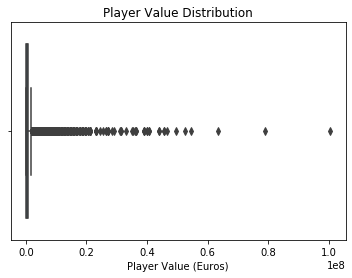

In [11]:
# lets look at the distrubtion of the response variable
sns.boxplot(fifa_15['value_eur'])
plt.xlabel('Player Value (Euros)')
plt.title('Player Value Distribution')
plt.show()

There are some major outliers here on the high end, but most of the players values are less than 2.5 millon euros in value. The distribution skewed to the right. 

Text(0.5, 0, 'Overall Rating')

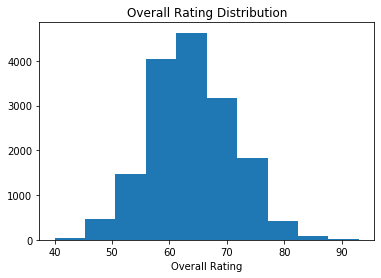

In [12]:
plt.title('Overall Rating Distribution')
plt.hist(fifa_15['overall'])
plt.xlabel('Overall Rating')

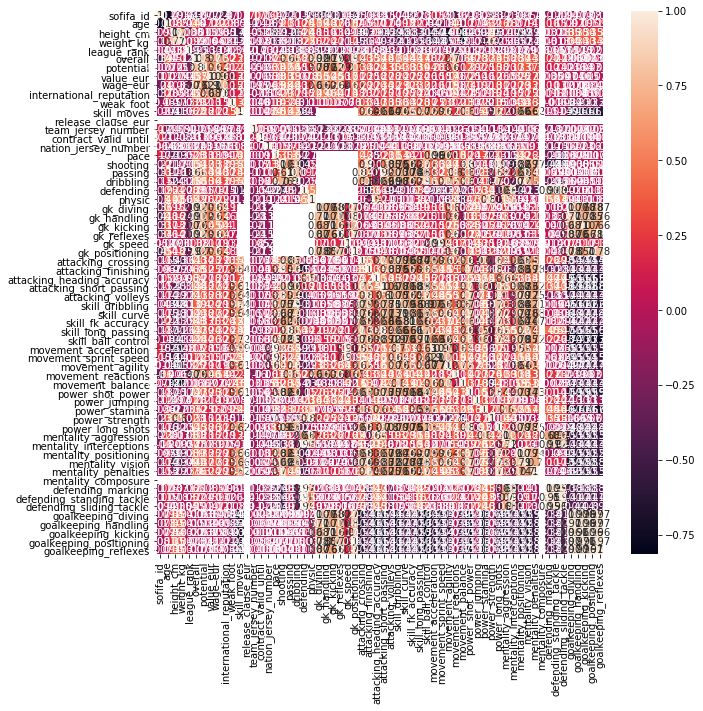

In [16]:
corr = fifa_15.corr(method = 'pearson')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot = True)

## PCA

In [25]:
pca = PCA(n_components = 2)
pca.fit(X_scaled)
X_reduced_2 = pca.transform(X_scaled)
print("explained variance ratio: {}".format(pca.explained_variance_))


explained variance ratio: [27.34523569  7.92207912]


Text(0, 0.5, 'Principal Component 2')

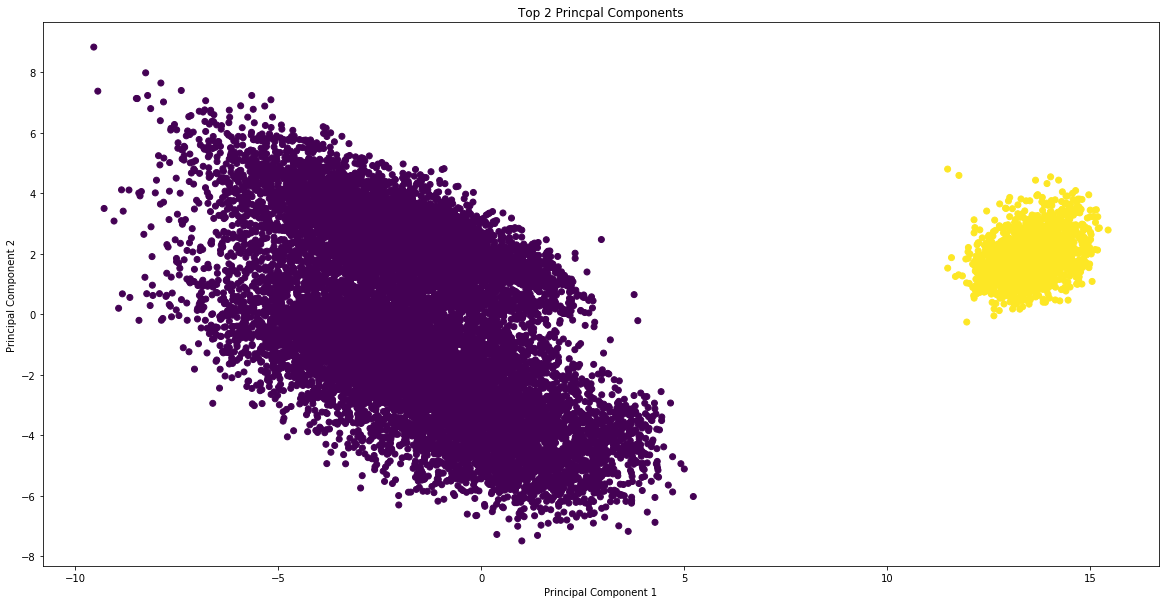

In [26]:
# plot the first 2 principal components and color by GK vs not GK
# the other half of the right cluster are subs and reserves players that are also goalkeepers
# check if the player has a missing value for pace (GK) and use this for plotting
is_gk = fifa_15['pace'].apply(lambda x: 1 if x != x else 0)
plt.scatter(X_reduced_2[:, 0], X_reduced_2[:,1], c = is_gk)
plt.title('Top 2 Princpal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

In [27]:
# lets limit the scope to only players to prevent the GK outliers

In [28]:
X_no_gk, y_no_gk = single_set_data_cleaning(fifa_15, False)
scaler2 = StandardScaler()
X_scaled_no_gk = scaler2.fit_transform(X_no_gk)

# No columns have any missing values
for idx, i in enumerate(sum(np.isnan(X_scaled_no_gk))):
    if i != 0:
        print("{}: {} missing values".format(X.columns[idx], i))


In [29]:
fifa_15[fifa_15['pace'].isna()]['team_position']

4         GK
21        GK
39        GK
43       SUB
53        GK
        ... 
16141    SUB
16144     GK
16145    SUB
16147    RES
16149    RES
Name: team_position, Length: 1775, dtype: object

In [30]:
pca2 = PCA(n_components = 2)
pca2.fit(X_scaled_no_gk)
X_reduced_no_gk = pca2.transform(X_scaled_no_gk)
print("explained variance ratio: {}".format(pca2.explained_variance_))


explained variance ratio: [15.68786443  9.18904592]


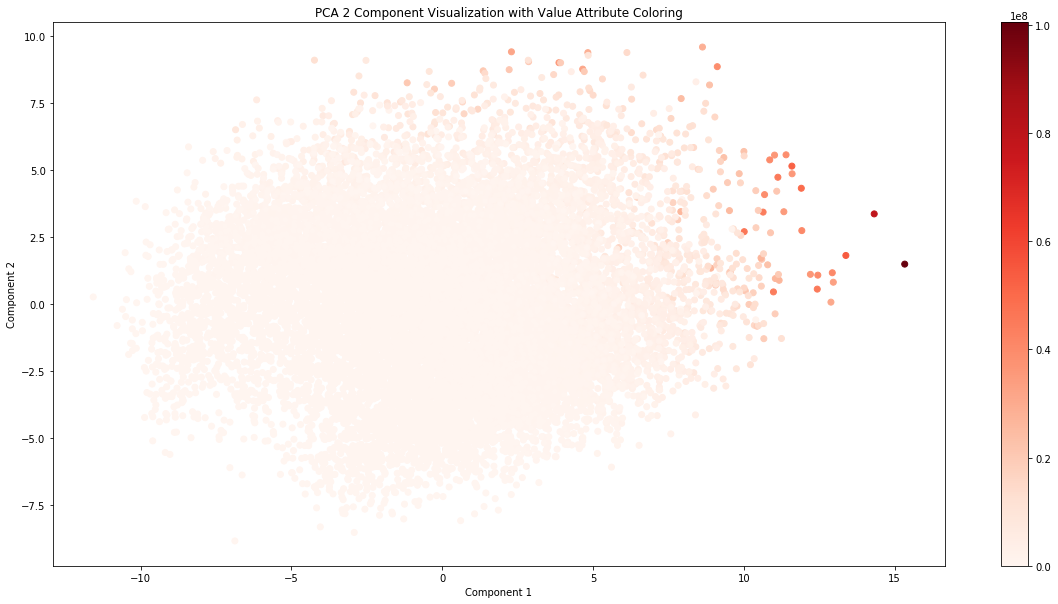

In [31]:
plt.title("PCA 2 Component Visualization with Value Attribute Coloring")
plt.scatter(X_reduced_no_gk[:, 0], X_reduced_no_gk[:,1], c = y_no_gk, cmap = 'Reds')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()

In [32]:
# as you can see, the PCA weights for the international reputation and overall variables are significantly higher
# than the other predictors, thus they are carrying most of the variaion in the principal components
print("Variable international reputation PCA weight: component 1 - {}, component 2 - {}".format(pca2.components_[0][list(X_no_gk.columns).index('international_reputation')], pca2.components_[1][list(X_no_gk.columns).index('international_reputation')]))
print("Variable Overall PCA weight: component 1 - {}, component 2 - {}".format(pca2.components_[0][list(X_no_gk.columns).index('overall')], pca2.components_[1][list(X_no_gk.columns).index('overall')]))

print('Median PCA weight: component 1 - {}, component 2 - {}'.format(np.median(pca2.components_[0]),np.median(pca2.components_[1])))

Variable international reputation PCA weight: component 1 - 0.08739689239709447, component 2 - 0.1195764459494443
Variable Overall PCA weight: component 1 - 0.15812896512608193, component 2 - 0.2079753002241612
Median PCA weight: component 1 - 0.008562761747537579, component 2 - 0.0035039300926076244
